## Train and test the final BrainTuning Contrastive Model

In [86]:
import numpy as np
import nibabel as nib
import nilearn 
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import pandas as pd
import seaborn as sns
import glob
from nilearn import plotting
from nilearn.image import *
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
from nilearn.plotting import plot_img, plot_epi
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler
import wandb
import pickle
from torch.utils.data import Dataset, DataLoader
from dataset import fMRI_Dataset, fMRI_Augmentation_Dataset
import torch
from torch import nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint

from pytorch_lightning.loggers import WandbLogger
from network import Encoder, ContrastiveModel
import torch
import torch.nn as nn
import pytorch_lightning as pl

In [87]:
use_augmentations = True   
sub = "CSI4"
wandb.login()
wandb.init(project="BrainTuning",config={"model":"best_image_model","single_subject":True, "augmentation":use_augmentations, "sub":sub})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [88]:
## load the data

train_datasets=[]
val_datasets=[]
test_datasets=[]

aumentation_N = 500


for subj in tqdm.tqdm([sub]):

    subj_id = int(subj.split("CSI")[1])

    data_path =  f"/home/matteo/storage/brain_tuning/{subj}"

    train_fmri = np.load(opj(data_path, "train_fmri_top.npy"))
    val_fmri = np.load(opj(data_path, "val_fmri_top.npy"))
    test_fmri = np.load(opj(data_path, "test_fmri_top.npy"))

    ##load the images
    img_train = np.load(opj(data_path, "img_train.npy"),allow_pickle=True)
    img_val = np.load(opj(data_path, "img_val.npy"),allow_pickle=True)
    img_test = np.load(opj(data_path, "img_test.npy"),allow_pickle=True)

    ## load the features
    train_features = np.load(opj(data_path, "train_image_features.npy"))
    val_features = np.load(opj(data_path, "val_image_features.npy"))
    test_features = np.load(opj(data_path, "test_image_features.npy"))

    if use_augmentations:
        print("Using augmentations")
        ## load the augmentations
        train_augmentations = np.load(opj(data_path, "augmented_brain.npy"))[:aumentation_N]
        
        # add a small noise to the augmentations
        train_augmentations = train_augmentations + np.random.normal(0,0.8,train_augmentations.shape)

        ## force the augmentations to have the same mean and std as the original fmri
        train_augmentations = train_augmentations - train_augmentations.mean(0)
        train_augmentations = train_augmentations/train_augmentations.std(0)
        train_augmentations = train_augmentations*train_fmri.std(0)
        train_augmentations = train_augmentations + train_fmri.mean(0)
        #set dtype to float32
        train_augmentations = train_augmentations.astype(np.float32)

        #load the augmented features
        train_augmented_features = np.load("/home/matteo/storage/brain_tuning/clean_augment_image_features.npy")[:aumentation_N]

        #concatenate the augmented and the original features
        train_fmri = np.concatenate([train_augmentations,train_fmri])
        train_features = np.concatenate([train_augmented_features,train_features])

        ## create the dataset
        train_dataset = fMRI_Augmentation_Dataset(train_fmri,train_features,subj_id) #no imags here, just features

    else:

        ## create the dataset
        train_dataset = fMRI_Dataset(train_fmri,img_train,train_features,subj_id)
    val_dataset = fMRI_Dataset(val_fmri,img_val,val_features,subj_id)
    test_dataset = fMRI_Dataset(test_fmri,img_test,test_features,subj_id)

    ## append the datasets
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    test_datasets.append(test_dataset)





  0%|          | 0/1 [00:00<?, ?it/s]

Using augmentations


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


In [89]:
## Concatenate the datasets
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
val_dataset = torch.utils.data.ConcatDataset(val_datasets)
test_dataset = torch.utils.data.ConcatDataset(test_datasets)


In [90]:
BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [91]:
## optimal parameter obtained from the hyperparameter search

act_fn = nn.Identity
base_channel_size = [2048]
hidden_dims = [1024]
latent_dim = 768

loss_type = "contrastive"
lr = 1e-4
temperature = 0.1
wd = 1e-5
alpha = 0.8

In [92]:
brain_model = ContrastiveModel(num_input_channels= 10000,
                                base_channel_size=base_channel_size, 
                                hidden_dims=hidden_dims,
                                latent_dim=latent_dim,
                                act_fn=act_fn,
                                loss_type=loss_type,
                                lr = lr,
                                wd = wd,
                                alpha=alpha)

# Set up early stopping to monitor 'val_loss'
early_stop_callback = EarlyStopping(monitor='val_loss', patience=1,verbose=True, mode='min')             # 'min' because we want to minimize val_loss
wandb_logger = WandbLogger()  # Logs the model and metrics to wandb


# Set up early stopping to monitor 'val_loss'
early_stop_callback = EarlyStopping(monitor='val_loss', patience=1,verbose=True, mode='min')             # 'min' because we want to minimize val_loss
wandb_logger = WandbLogger()  # Logs the model and metrics to wandb


# Create a unique checkpoint directory based on the run name or ID
run_name = wandb.run.name or wandb.run.id  # Use run name if available, otherwise use run ID
checkpoint_dir = os.path.join(data_path, "models",sub, run_name)
os.makedirs(checkpoint_dir, exist_ok=True)

# Model checkpoint configuration
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath=checkpoint_dir,filename='{sub}_brain_model-{epoch:02d}-{val_loss:.2f}',save_top_k=3,mode='min',)


# Initialize trainer with logger

trainer = pl.Trainer(max_epochs=20, devices=[1], callbacks=[early_stop_callback,checkpoint_callback],logger=wandb_logger ) # Add the wandb logger here

trainer.fit(brain_model, train_loader, val_loader)

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/matteo/anaconda3/envs/borg/lib/python3.8/site- ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  6.49it/s, v_num=jbvl, train_loss_step=4.730, val_loss=5.400, val_mse_loss=1.780, val_cosine_similarity=0.0901, train_loss_epoch=5.940]

Metric val_loss improved. New best score: 5.403


Epoch 1: 100%|██████████| 6/6 [00:00<00:00,  9.76it/s, v_num=jbvl, train_loss_step=3.990, val_loss=5.160, val_mse_loss=1.710, val_cosine_similarity=0.127, train_loss_epoch=5.080] 

Metric val_loss improved by 0.246 >= min_delta = 0.0. New best score: 5.158


Epoch 2: 100%|██████████| 6/6 [00:00<00:00,  8.66it/s, v_num=jbvl, train_loss_step=3.550, val_loss=5.000, val_mse_loss=1.670, val_cosine_similarity=0.149, train_loss_epoch=4.600]

Metric val_loss improved by 0.156 >= min_delta = 0.0. New best score: 5.001


Epoch 3: 100%|██████████| 6/6 [00:00<00:00,  9.99it/s, v_num=jbvl, train_loss_step=3.160, val_loss=4.880, val_mse_loss=1.640, val_cosine_similarity=0.164, train_loss_epoch=4.200]

Metric val_loss improved by 0.119 >= min_delta = 0.0. New best score: 4.882


Epoch 4: 100%|██████████| 6/6 [00:00<00:00,  7.37it/s, v_num=jbvl, train_loss_step=2.850, val_loss=4.790, val_mse_loss=1.630, val_cosine_similarity=0.171, train_loss_epoch=3.850]

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 4.793


Epoch 5: 100%|██████████| 6/6 [00:00<00:00,  9.50it/s, v_num=jbvl, train_loss_step=2.540, val_loss=4.730, val_mse_loss=1.620, val_cosine_similarity=0.175, train_loss_epoch=3.530]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 4.733


Epoch 6: 100%|██████████| 6/6 [00:00<00:00,  8.37it/s, v_num=jbvl, train_loss_step=2.270, val_loss=4.690, val_mse_loss=1.610, val_cosine_similarity=0.178, train_loss_epoch=3.230]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 4.685


Epoch 7: 100%|██████████| 6/6 [00:00<00:00,  9.85it/s, v_num=jbvl, train_loss_step=2.050, val_loss=4.650, val_mse_loss=1.610, val_cosine_similarity=0.180, train_loss_epoch=2.960]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 4.647


Epoch 8: 100%|██████████| 6/6 [00:00<00:00,  7.44it/s, v_num=jbvl, train_loss_step=1.790, val_loss=4.620, val_mse_loss=1.600, val_cosine_similarity=0.182, train_loss_epoch=2.730]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 4.619


Epoch 9: 100%|██████████| 6/6 [00:00<00:00, 10.47it/s, v_num=jbvl, train_loss_step=1.640, val_loss=4.600, val_mse_loss=1.600, val_cosine_similarity=0.182, train_loss_epoch=2.500]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 4.599


Epoch 10: 100%|██████████| 6/6 [00:00<00:00,  7.55it/s, v_num=jbvl, train_loss_step=1.450, val_loss=4.580, val_mse_loss=1.600, val_cosine_similarity=0.183, train_loss_epoch=2.310]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 4.581


Epoch 11: 100%|██████████| 6/6 [00:00<00:00, 10.04it/s, v_num=jbvl, train_loss_step=1.370, val_loss=4.570, val_mse_loss=1.600, val_cosine_similarity=0.183, train_loss_epoch=2.130]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 4.567


Epoch 12: 100%|██████████| 6/6 [00:00<00:00,  7.84it/s, v_num=jbvl, train_loss_step=1.150, val_loss=4.560, val_mse_loss=1.600, val_cosine_similarity=0.183, train_loss_epoch=1.960]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 4.559


Epoch 13: 100%|██████████| 6/6 [00:00<00:00,  9.83it/s, v_num=jbvl, train_loss_step=1.070, val_loss=4.550, val_mse_loss=1.600, val_cosine_similarity=0.184, train_loss_epoch=1.820]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 4.548


Epoch 14: 100%|██████████| 6/6 [00:00<00:00,  8.17it/s, v_num=jbvl, train_loss_step=0.979, val_loss=4.540, val_mse_loss=1.600, val_cosine_similarity=0.183, train_loss_epoch=1.690]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 4.544


Epoch 15: 100%|██████████| 6/6 [00:00<00:00, 10.92it/s, v_num=jbvl, train_loss_step=0.888, val_loss=4.540, val_mse_loss=1.600, val_cosine_similarity=0.184, train_loss_epoch=1.580]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 4.541


Epoch 16: 100%|██████████| 6/6 [00:00<00:00,  7.20it/s, v_num=jbvl, train_loss_step=0.788, val_loss=4.540, val_mse_loss=1.600, val_cosine_similarity=0.184, train_loss_epoch=1.480]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 4.536


Epoch 17: 100%|██████████| 6/6 [00:00<00:00, 10.85it/s, v_num=jbvl, train_loss_step=0.772, val_loss=4.530, val_mse_loss=1.600, val_cosine_similarity=0.183, train_loss_epoch=1.380]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 4.534


Epoch 18: 100%|██████████| 6/6 [00:00<00:00,  7.45it/s, v_num=jbvl, train_loss_step=0.728, val_loss=4.530, val_mse_loss=1.600, val_cosine_similarity=0.183, train_loss_epoch=1.300]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 4.532


Epoch 19: 100%|██████████| 6/6 [00:00<00:00, 10.81it/s, v_num=jbvl, train_loss_step=0.623, val_loss=4.540, val_mse_loss=1.600, val_cosine_similarity=0.182, train_loss_epoch=1.230]

Monitored metric val_loss did not improve in the last 1 records. Best score: 4.532. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 6/6 [00:00<00:00,  7.07it/s, v_num=jbvl, train_loss_step=0.623, val_loss=4.540, val_mse_loss=1.600, val_cosine_similarity=0.182, train_loss_epoch=1.230]


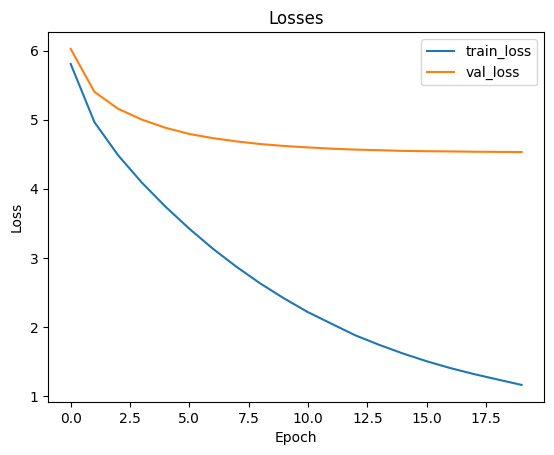

<Figure size 640x480 with 0 Axes>

In [93]:
## plot the losses
output_path = "/home/matteo/storage/brain_tuning/"

plt.plot(brain_model.train_history['train_loss'], label='train_loss')
plt.plot(brain_model.val_history['val_loss'][:-1], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')

plt.show()

if use_augmentations:
## save the plot
    plt.savefig(opj(output_path,f"single_subject_{sub}_augmented_losses.png"))
else:
    ## save the plot
    plt.savefig(opj(output_path,f"single_subject_{sub}_losses.png"))

In [94]:
# from image_evaluation import *
# import importlib
# import image_evaluation
# importlib.reload(image_evaluation)
from image_evaluation import *


## Evaluation

In [95]:
results_df, similarity_matrices, results = evaluate_and_log(test_loader,brain_model)


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Starting evaluation...
Evaluating metrics for subject 4...
Computed similarity matrix for subject 4.
Top-1 Accuracy: 0.0278, Top-5 Accuracy: 0.1435 for subject 4.
Identification accuracy for subject 4: 0.8740
Logged top-5 retrievals for subject 4.
Evaluation complete. Results loaded to wandb.


In [96]:
results_df

Subject  Identification Accuracy (%)  ID Accuracy Baseline (%)  \
0        4                     87.40063                        50   

   Top-1 Accuracy (%)  Top1 Baseline (%)  Top1 Improvement Over Baseline  \
0            2.783726           0.214133                            13.0   

   Top-5 Accuracy (%)  Top5 Baseline (%)  Top5 Improvement Over Baseline  
0           14.346895           1.070664                            13.4

In [97]:
## save the results

if use_augmentations:
    results_df.to_csv(opj(output_path,f"results_augmented_contrastive_{sub}.csv"))
else:

    results_df.to_csv(opj(output_path,f"results_image_contrastive_{sub}.csv"))

In [98]:
def get_good_example_indices(similarity_matrix, gt_images, num_examples=10):
    """
    Get indices of good examples where the retrieved images include the stimulus image in the top-5.
    
    Args:
        similarity_matrix (np.array): Cosine similarity matrix between predicted and ground truth embeddings.
        gt_images (list): List of ground truth images.
        num_examples (int): Number of good examples to retrieve.

    Returns:
        List of tuples: Each tuple contains (stimulus_index, top5_indices), where:
                        - stimulus_index is the index of the stimulus image.
                        - top5_indices are the indices of the top-5 retrieved images.
    """
    # Identify indices where the correct image is among the top-5 retrieved
    good_examples_indices = [
        i for i in range(len(gt_images)) if i in np.argsort(-similarity_matrix[i])[:5]
    ]
    
    # Randomly select up to `num_examples` from good examples
    if len(good_examples_indices) > num_examples:
        good_examples_indices = np.random.choice(good_examples_indices, num_examples, replace=False)
    
    # Gather (stimulus_index, top5_indices) for each good example
    example_indices = []
    for i in good_examples_indices:
        sim_scores = similarity_matrix[i]
        top5_indices = np.argsort(-sim_scores)[:5]
        example_indices.append((i, top5_indices.tolist()))

    return example_indices

good_example_indices = get_good_example_indices(similarity_matrices[subj_id], results[subj_id]["gt_images"])
good_example_indices  # [(stimulus_index, [top5_index1, top5_index2, ..., top5_index5]), ...]


[(207, [274, 421, 330, 207, 379]),
 (265, [265, 419, 131, 71, 188]),
 (239, [397, 357, 289, 239, 303]),
 (341, [427, 42, 106, 35, 341]),
 (398, [398, 355, 196, 27, 303]),
 (80, [124, 151, 80, 272, 73]),
 (213, [103, 120, 347, 129, 213]),
 (167, [168, 385, 149, 167, 18]),
 (411, [411, 372, 102, 445, 267]),
 (32, [456, 32, 294, 87, 51])]

In [99]:
print("Done",sub,use_augmentations)

Done CSI4 True


In [100]:
def get_random_example_indices(similarity_matrix, gt_images, num_examples=10):
    """
    Get random indices to visualize general performance of the model, with the top-5 retrieved images.
    
    Args:
        similarity_matrix (np.array): Cosine similarity matrix between predicted and ground truth embeddings.
        gt_images (list): List of ground truth images.
        num_examples (int): Number of random examples to retrieve.

    Returns:
        List of tuples: Each tuple contains (stimulus_index, top5_indices), where:
                        - stimulus_index is the index of the stimulus image.
                        - top5_indices are the indices of the top-5 retrieved images.
    """
    # Select random indices for visualization
    random_indices = np.random.choice(range(len(gt_images)), num_examples, replace=False)
    
    # Gather (stimulus_index, top5_indices) for each random example
    example_indices = []
    for i in random_indices:
        sim_scores = similarity_matrix[i]
        top5_indices = np.argsort(-sim_scores)[:5]
        example_indices.append((i, top5_indices.tolist()))

    return example_indices

random_example_indices = get_random_example_indices(similarity_matrices[subj_id], results[subj_id]["gt_images"])
# random_example_indices  # [(stimulus_index, [top5_index1, top5_index2, ..., top5_index5]), ...]


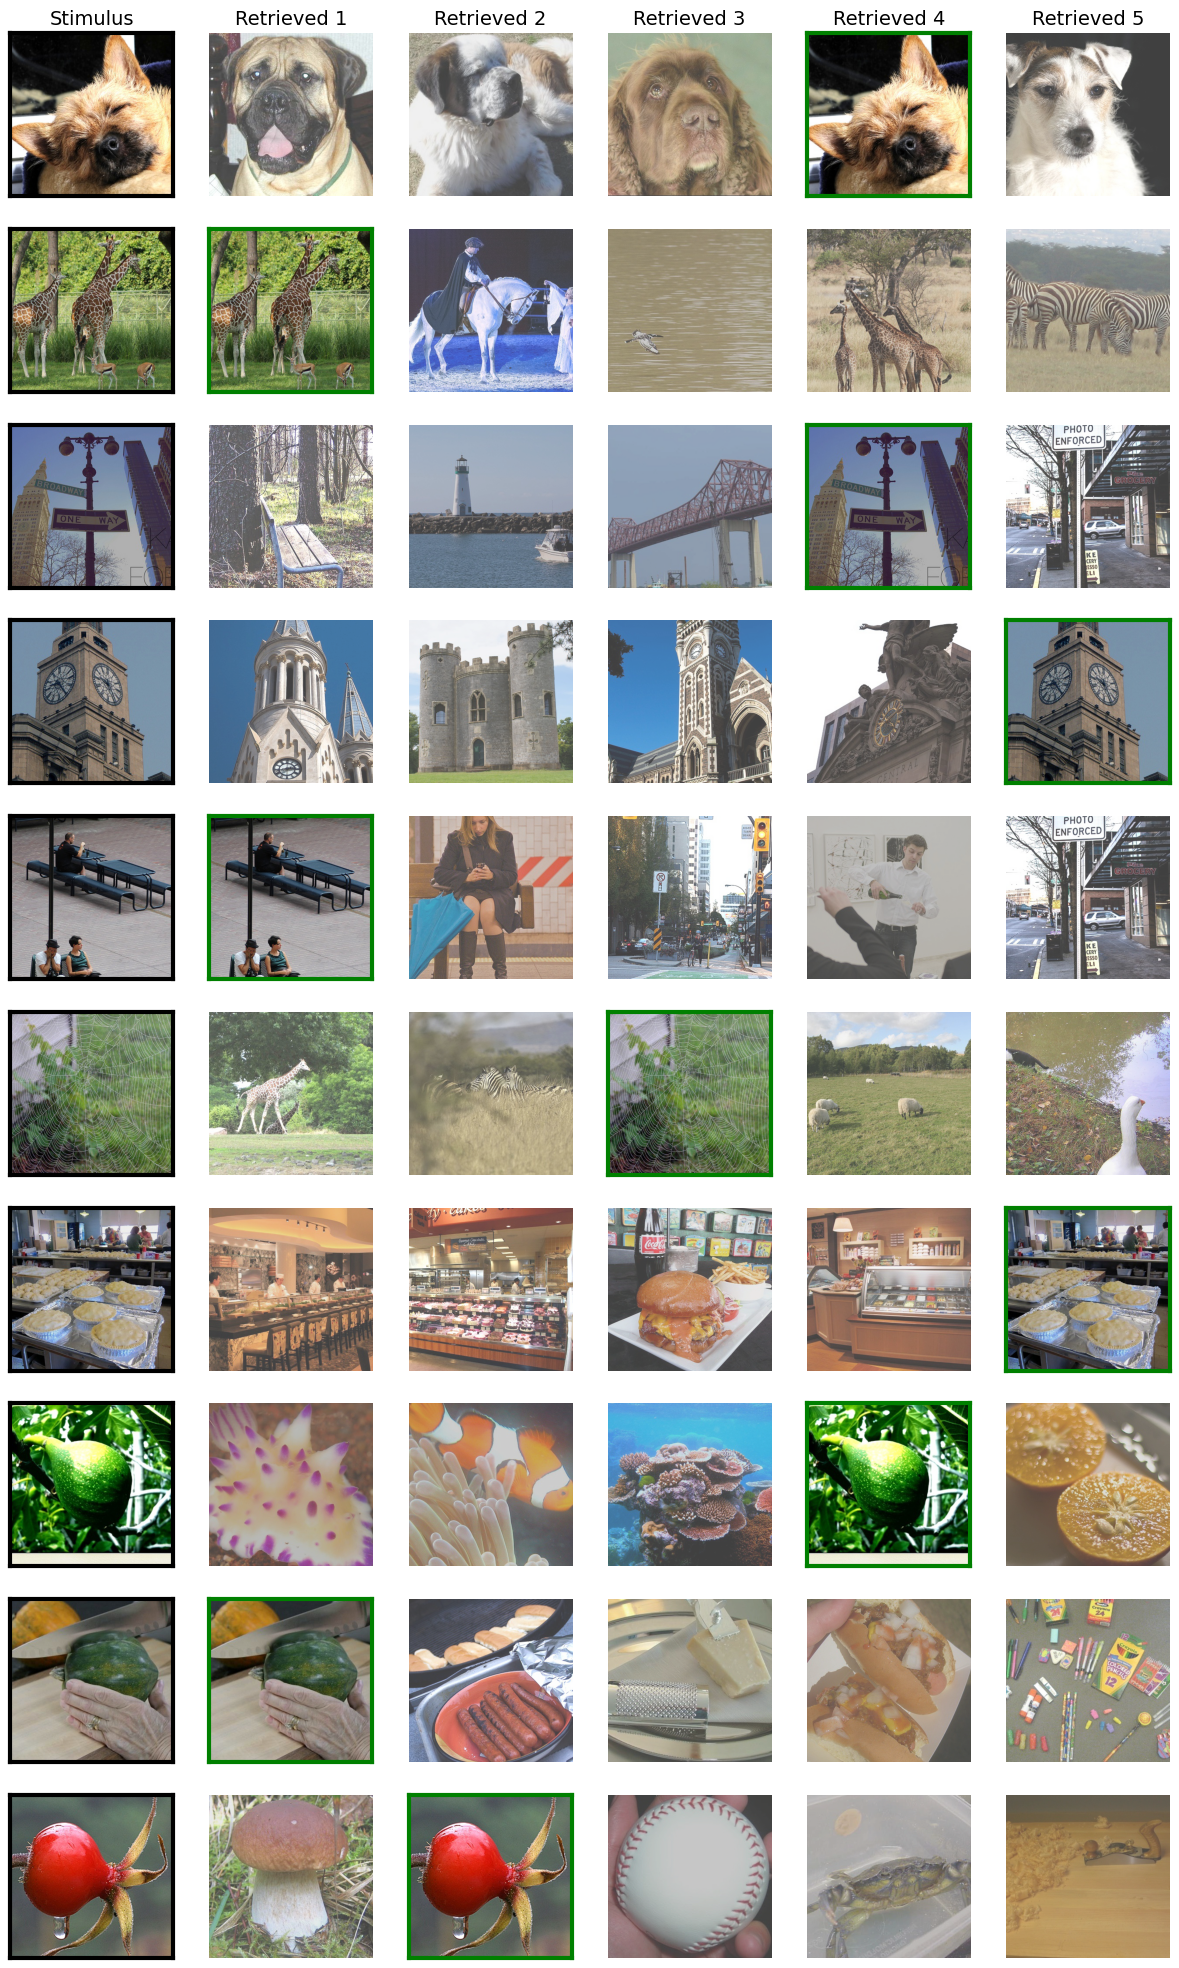

In [102]:
import matplotlib.pyplot as plt
def plot_examples(gt_images, example_indices,output_name="examples.png",alpha=0.75):
    """
    Plot the stimulus and top-5 retrieved images for each good example.

    Args:
        gt_images (list): List of ground truth images (as PIL images or arrays).
        example_indices (list): List of tuples with (stimulus_index, top5_indices) for good examples.
    """
    num_examples = len(example_indices)
    fig, axes = plt.subplots(num_examples, 6, figsize=(15, 2.5 * num_examples), facecolor="white")
    
    for i, (stimulus_index, top5_indices) in enumerate(example_indices):
        # Plot the stimulus image with a black border
        axes[i, 0].imshow(gt_images[stimulus_index].permute(1, 2, 0))
        axes[0, 0].set_title("Stimulus", fontsize=14)
        for spine in axes[i, 0].spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(3)
        # Remove ticks and labels without turning off the entire axis
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])

        # Plot the top-5 retrieved images, adding a green border for the correct retrieval
        for j, top5_idx in enumerate(top5_indices):
            axes[0, j + 1].set_title(f"Retrieved {j + 1}", fontsize=14)
            
            # If the retrieved image is the correct one, add a green border
            if top5_idx == stimulus_index:
                axes[i, j + 1].imshow(gt_images[top5_idx].permute(1, 2, 0))

                for spine in axes[i, j + 1].spines.values():
                    
                    spine.set_edgecolor("green")
                    spine.set_linewidth(3)
            else:
                axes[i, j + 1].imshow(gt_images[top5_idx].permute(1, 2, 0),alpha=alpha)

                axes[i,j+1].axis('off')
            # Remove ticks and labels
            axes[i, j + 1].set_xticks([])
            axes[i, j + 1].set_yticks([])

    # plt.tight_layout()
    plt.savefig(output_name)
    plt.show()

if use_augmentations:
    plot_examples(results[subj_id]["gt_images"], good_example_indices,output_name=opj(output_path, f"good_examples_augmented_{sub}.png"))

else:
    plot_examples(results[subj_id]["gt_images"], good_example_indices,output_name=opj(output_path, f"good_examples_{sub}.png"))

## save the plot


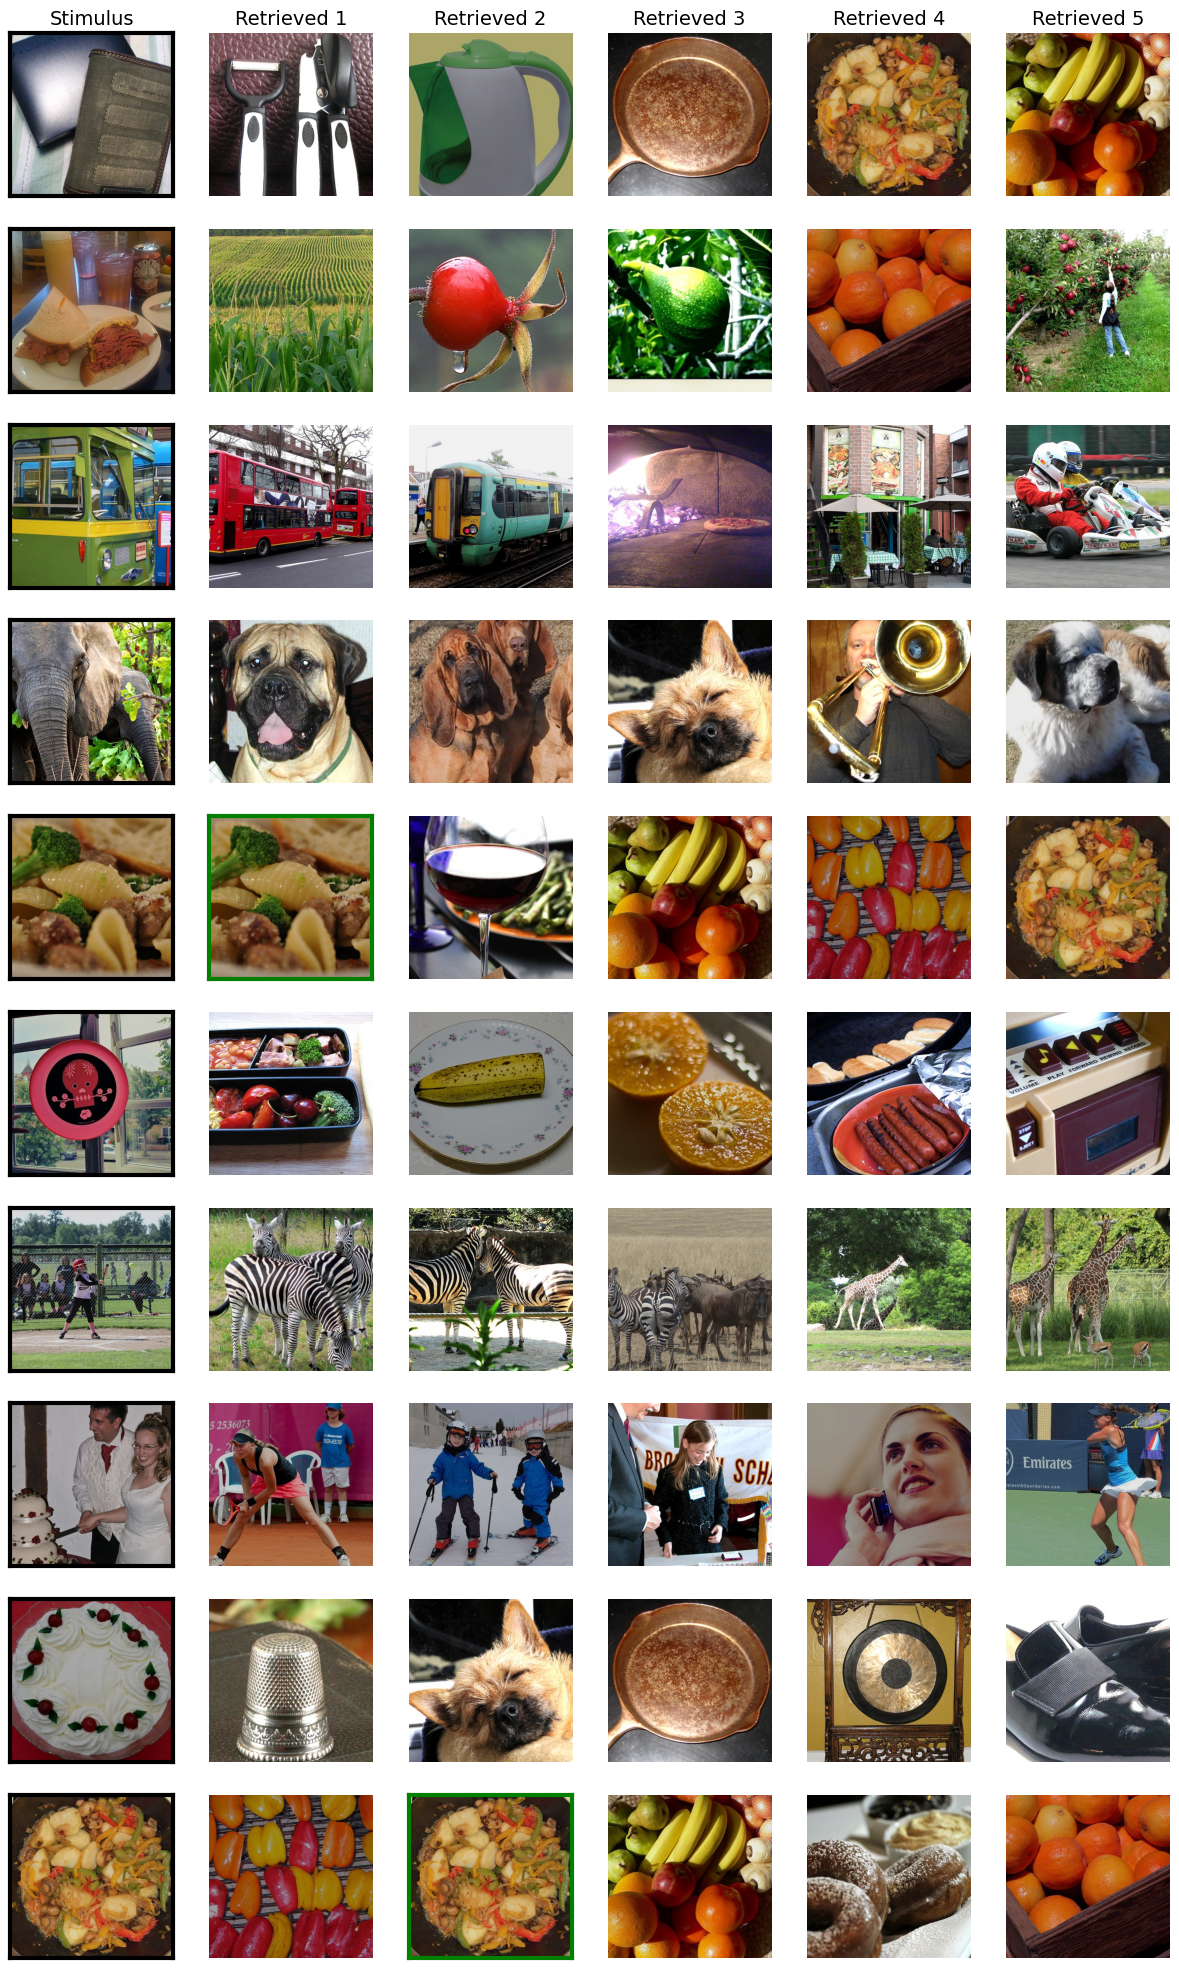

In [103]:
if use_augmentations:
    plot_examples(results[subj_id]["gt_images"], random_example_indices,output_name=opj(output_path, f"random_examples_augmented_{sub}.png"),alpha=1)
else:
    plot_examples(results[subj_id]["gt_images"], random_example_indices,output_name=opj(output_path, f"random_examples_{sub}.png"),alpha=1)


Done CSI1 True
